#    Data 620, Project 1
Team 6: Alice Friedman, Jun Pan, Stephen (Scott) Jones, and Jeff Littlejohn
June 19, 2019

## Introduction
Candidates, parties, journalists, and a steadily increasing share of the public are using Twitter to comment on, interact around, and research public reactions to politics (Jungheer 2016). Use of Twitter can be modeled as a network in several ways: Users can be described as nodes and edges can be described as they follow, reply and mention one another. These connections are visible in the text of each tweet or by requesting lists of the users that follow the author of each tweet from Twitter. Additionally, Tweets themselves can be nodes that are linked to each other in a chain of retweets. Users are tagged with a variety of categorial data including language, location, and verfication status.

A recent feature by Jamie Lauren Keiles in the New York Times Magazine, (Are These Teenagers Really Running a Presidential Campaign? Yes. (Maybe.)”), describes the unorthodox strategy of presidential hopeful and former Senator Mike Gravel, who has turned his social media campaign over to a pair of teenagers. Teenagers are more active than other age groups by accessing social media tools such as Twitter, Facebook and Instagram, but are much less likely to vote than older Americans (especially since by definition most of them aren't old enough!).

We propose to investigate the network of users who retweet Mike Gravel's official campaign account in order to ascertain whether his strategy is reaching political influencers.

Twitter data is available through as JSON through a tiered API. Free versions of the API provide a sample of Tweets available for the last week.

Althought retweets provide a more robust model for a social network, acquiring followship data on Twitter is considerably less complex. Therefore, we will model the network with [@mikegravel](https://twitter.com/mikegravel) as the ego, a sample of his followers, and a sample of his followers' followers.

## Part 1: Import packages

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import urllib.request, json 
from twython import Twython
import time

## Part 2: Data Scraping

The following scripts were run the week of June 9 to access the Twitter API. Because calls are rate limited and credetials must be secured, data was then loaded into JSON files and shared via git.

Due to limitations on the Twitter API free-tier, this data will pull a sample of all followership rather than a full picture. This may impact the analysis, althought code developed for this sample would work on a larger dataset as well. 

### Scrape followers of ego

In [ ]:
# Code below adapated from: https://stackabuse.com/accessing-the-twitter-api-with-python/
# Load Twitter API credentials from json file
with open("twitter_credentials.json", "r") as file:  
    creds = json.load(file)

# Instantiate an object and provide Twitter credentials
twitter = Twython(creds['CONSUMER_KEY'], creds['CONSUMER_SECRET_KEY'], creds['ACCESS_TOKEN'], creds['ACCESS_SECRET_TOKEN'])

# create empty dictionary to accept data
dict_fol = {'screen_name': [], 'verified': [], 'followers_count': []}  

# we don't want to dump directly to the graph because we'll get a giant hairball
# we will want to filter for users with more followers before moving to depth=2 of the social network

#create loop to page through API results
next_cursor = -1

while(next_cursor):
    get_followers = twitter.get_followers_list(screen_name='mikegravel', cursor=next_cursor)
    for user in get_followers['users']:  
        dict_fol['screen_name'].append(user['screen_name'])
        dict_fol['verified'].append(user['verified'])
        dict_fol['followers_count'].append(user['followers_count'])
        time.sleep(75) # avoids running into the API rate limit, which accepts 15 calls every 15 minutes
        
# due to rate limits, have saved a sample of the results into a json file for later reloading
with open("mikegravel_followers.json", "w") as file:  
    json.dump(dict_fol, file)

### Define a function to scrape data for multiple accounts
Having proved the concept, we will know develop a function to loop through a list of @mikegravel's followers to obtain the second-level follower lists. How does this script work?

1. First, we instantiate a Twython object, which we call "twitter"--this is basically a vehicle for telling Twitter that we have credentials to access the API.

2. Next, we create an empty dictionary with the fields we are looking to connect

3. Then, we creat a loop to page through the API results and add them to our dictionary. This is really the key part of the function. 

4. Last, we dump the data into a JSON file. One reason to do it this way is so that we aren't eating up all of our memory by holding all the results in different data forms. Every time the function runs, we are overwriting the dictionary.

In [3]:
def get_followers_json(username):
    try:
        # Load Twitter API credentials from json file
        with open("twitter_credentials.json", "r") as file:  
            creds = json.load(file)

        # 1) Instantiate an object and provide Twitter credentials
        twitter = Twython(creds['CONSUMER_KEY'], creds['CONSUMER_SECRET_KEY'], creds['ACCESS_TOKEN'], creds['ACCESS_SECRET_TOKEN'])# create empty dictionary to accept data
        
        # 2) Create empty dictionary
        dict_fol = {'screen_name': [], 'verified': [], 'followers_count': []}  
    
        # 3) Create loop to page through API results
        next_cursor = -1
        timeout = time.time() + 60*60 #creates a hard end time for the script to run

        while(next_cursor):
            if time.time() > timeout:
                break #ends loop after timeout period
            get_followers = twitter.get_followers_list(screen_name = username, count=1000, cursor=next_cursor)
            print("Getting %s's followers" % username)
            for user in get_followers['users']:  
                dict_fol['screen_name'].append(user['screen_name'])
                dict_fol['verified'].append(user['verified'])
                dict_fol['followers_count'].append(user['followers_count'])
            try: 
                time.sleep(65)
                next_cursor = get_followers["next_cursor"]
            except:
                break #this lets us save progress if we run into a timeout mid-data stream

        # 4) write data to file
        filename=username + "_followers.json"
    
        with open(filename, "w") as file:
            json.dump(dict_fol, file)
        
        print("Saving %s's followers to JSON file" % username)
    
    except: #in case it doesn't work, this prints a message to tell us the script is still running
        i = 15
        while i > 0:
            print("Waiting for API rate limit to reset. Will try again in %d minutes" % i)
            time.sleep(60) #Twitter API rate limits reset after 15 minutes
            i -= 1
        get_followers_json(username) #then it will try again

### Get list to run through

Using the JSON file previously obtained, we can now create a list of top followers to use as the input for our function.

In [7]:
#get list of followers to try to get followers of

head = "https://raw.githubusercontent.com/aliceafriedman/Data620/master/Project1data/"
username = 'mikegravel'
tail = "_followers.json"
url = head + username + tail

with urllib.request.urlopen(url) as url:
    mg_fol_json = json.loads(url.read().decode())   

#turn into pandas dataframe
df_followers = pd.DataFrame(mg_fol_json)
df_followers.sort_values(by='followers_count', inplace=True, ascending=False)
df_followers = df_followers[df_followers.followers_count >500]
df_followers = df_followers.drop_duplicates()

followers_to_get = df_followers['screen_name'].unique()


### Run through list to acquire remaining data

Lastly, we apply our function to the list to acquire our remaining data.

Note: Due to rate limits, this code is not run in this Jupyter notebook.

In [8]:
#run through list of followers to get followers of
for follower in followers_to_get:
    get_followers_json(follower)

Waiting for API rate limit to reset. Will try again in 15 minutes


KeyboardInterrupt: 

## Part 3: Load Data from Files

After all data was scraped from the Twitter API and output to files, we can create a new function to load and clean the scaped data. 

This can be done with a function because all the files are stored in a systematic way.

### Create function to load files

In [9]:
def convert_to_df(username):
    # get url from github (works because file names are systematic)              
    head = "https://raw.githubusercontent.com/aliceafriedman/Data620/master/Project1data/"
    tail = "_followers.json"
    url = head + username + tail
    print(url)
    # open url
    with urllib.request.urlopen(url) as url:
         dict_followers = json.loads(url.read().decode())   
    
    #turn into pandas dataframe
    df_followers = pd.DataFrame.from_dict(dict_followers)
    df_followers.sort_values(by='followers_count', inplace=True, ascending=False)
    df_followers = df_followers[df_followers.followers_count >500]
    df_followers = df_followers.drop_duplicates()
    
    #add column to show follo
    df_followers['source'] = username
    df_followers['screen_name'] = df_followers['screen_name'].str.lower()
    
    print("Head of converted dataframe for %s\n" % username)
    print(df_followers[:5])
    print("\n")
    
    return df_followers



### Generate list of followers to get
Now, we can run the function over all of our data to create dataframes for each user. But which followers should we get? We will create a list from our original dataframe, and work through as many as we can, from most to least followers before we hit the final API rate limit. 

Note: This is the same list we generated above when scraping the Twitter API.

In [10]:
df_followers = convert_to_df('mikegravel')
followers_to_get = df_followers['screen_name'].unique()[:17] #due to rate limit constraints, 
#we were able to actually get the top 17 followers data, only

followers_to_get.sort()

print(followers_to_get) 

https://raw.githubusercontent.com/aliceafriedman/Data620/master/Project1data/mikegravel_followers.json
Head of converted dataframe for mikegravel

        screen_name  verified  followers_count      source
1084        tankcat      True             5183  mikegravel
474         tankcat      True             5182  mikegravel
638     abigail1963     False             4272  mikegravel
964    adomgetachew     False             2654  mikegravel
848   acttogetherfl     False             2381  mikegravel


['abigail1963' 'acttogetherfl' 'adomgetachew' 'ajfeather' 'goddessmasha'
 'helloise7' 'jarongubernick' 'kateah' 'kimfinnie' 'lazybastid'
 'oshiserves' 'politicutie' 'robyn459' 'tankcat' 'thesecondgoing'
 'tucsonmike' 'zacharywelliott']


### Run loop over list to create master dataframe

Using a "for" loop, we can quickly download, convert, and lightly clean all the JSON files into one "master" dataframe. 

In [11]:
master = pd.DataFrame()
for follower in followers_to_get:
    frame = convert_to_df(follower)
    master = master.append(frame)

https://raw.githubusercontent.com/aliceafriedman/Data620/master/Project1data/abigail1963_followers.json
Head of converted dataframe for abigail1963

         screen_name  verified  followers_count       source
371      cooperativa      True          2694253  abigail1963
193     amandapalmer      True          1082703  abigail1963
740          911well     False           631243  abigail1963
831  high_on_glitter     False           615026  abigail1963
860     bella__angel     False           609247  abigail1963


https://raw.githubusercontent.com/aliceafriedman/Data620/master/Project1data/acttogetherfl_followers.json
Head of converted dataframe for acttogetherfl

         screen_name  verified  followers_count         source
261    whatstrending      True           870298  acttogetherfl
645        iraqesque     False           679472  acttogetherfl
946         meldmann     False           599417  acttogetherfl
542  chaelmontgomery     False           430357  acttogetherfl
660     alicema

Head of converted dataframe for zacharywelliott

         screen_name  verified  followers_count           source
384         j4ckmull      True           520689  zacharywelliott
1        pascalguyon      True           502448  zacharywelliott
232      briandevans      True           463161  zacharywelliott
36   chaelmontgomery     False           430358  zacharywelliott
89        georg_grey     False           365476  zacharywelliott




### Remove duplicates and sort

In [12]:
#deduplicate, keeping the record containing the largest follower count

dedup = pd.DataFrame(master)
dedup.sort_values(by=['screen_name','followers_count'], ascending=[True,False], inplace = True) 
dedup.drop_duplicates(subset="screen_name", keep='first', inplace = True)
dedup.head(15)
dedup.tail(15)

screen_name  verified  followers_count           source
936     zombiecirc     False             2618   jarongubernick
197      zoogerdee     False            21015   jarongubernick
541       zookmann      True            58582         robyn459
251       zornbree     False             2595    acttogetherfl
189         zote63     False             1234           kateah
722       zsmokeyz     False            23840  zacharywelliott
235         ztoesq     False             1522      politicutie
754  ztotheotothee     False              544       oshiserves
900      ztsamudzi     False            64213     adomgetachew
526    zulmahawaii     False             1551     goddessmasha
459     zunguzungu     False            16053     adomgetachew
489       zuristar     False            56476       tucsonmike
328   zwanelungele     False             1654   jarongubernick
391         zynr07     False             5884        helloise7
276          zyx_1     False              901         robyn459

### Check for missing (known) connections
Because we are working with a sample of data, we need to check @mikegravel's follower list for connections of each follower we've profiled.

In [13]:
#check for connectivity; clementine is missing
from pandas import DataFrame
answer = dedup.loc[(dedup['screen_name'] == "mslizclementine") | (dedup['screen_name'] == "tankcat") |
                     (dedup['screen_name'] == "dedup") | (dedup['screen_name'] == "acttogetherfl") | 
                    (dedup['screen_name'] == "adomgetachew") | (dedup['screen_name'] == "kateah") | 
                    (dedup['screen_name'] == "thesecondgoing") | (dedup['screen_name'] == "tucsonmike") | 
                    (dedup['screen_name'] == "zacharywelliott")]

print(answer)

Empty DataFrame
Columns: [screen_name, verified, followers_count, source]
Index: []


Add mslizclementine as a follower of gravel; her current follower count is 5 and she is not a verified user. Then check again for connections of each follower we've profiled; we're looking to see if mslizclementine is added.

In [14]:
isource = "gravel"
iscreen_name = "mslizclementine"
ifollowers_count = 5
iverified = False

dedup = dedup.append(pd.DataFrame([[iscreen_name,iverified,ifollowers_count,isource]], columns
=dedup.columns))

Check again for connections of each follower we've profiled.

In [15]:
answer = dedup.loc[(dedup['screen_name'] == "mslizclementine") | (dedup['screen_name'] == "tankcat") |
                     (dedup['screen_name'] == "dedup") | (dedup['screen_name'] == "acttogetherfl") | 
                    (dedup['screen_name'] == "adomgetachew") | (dedup['screen_name'] == "kateah") | 
                    (dedup['screen_name'] == "thesecondgoing") | (dedup['screen_name'] == "tucsonmike") | 
                    (dedup['screen_name'] == "zacharywelliott")]

print(answer)

       screen_name  verified  followers_count  source
0  mslizclementine     False                5  gravel


Now that all followers are included, calculate the log of the follower count to compress the scale, masking those records with value of 0.

In [16]:
#calculate the log of the follower count to compress the scale, masking those records with value of 0.
mask = (dedup['followers_count'] != 0)
dedup_valid = dedup[mask]

dedup['log_fc'] = 0
dedup.loc[mask, 'log_fc'] = np.log(dedup_valid['followers_count'])

In [17]:
#remove those with fewer than 3 followers
master1=dedup.loc[dedup['followers_count'] > 3]

#sort before reindexing
master1 = master1.sort_values(by=['followers_count'])

master1.reset_index(inplace=True)

#delete extra obselete index of each separate dataframe
del master1['index']

print(master1)

          screen_name  verified  followers_count          source     log_fc
0     mslizclementine     False                5          gravel   1.609438
1        bosnaireland     False              501  thesecondgoing   6.216606
2       nymediacritic     False              501          kateah   6.216606
3      dennisbright12     False              501       ajfeather   6.216606
4     vonnegutterball     False              501     politicutie   6.216606
5           hollis517     False              501   acttogetherfl   6.216606
6          astrodan13     False              502     abigail1963   6.218600
7     jessicaxnuaghty     False              502      oshiserves   6.218600
8         nelson_nec_     False              502       ajfeather   6.218600
9           nfl_agent     False              502      tucsonmike   6.218600
10         fxfauvelle     False              503    adomgetachew   6.220590
11      interludearch     False              503  thesecondgoing   6.220590
12         a

## Plot Data

Now we can use NetworkX to create a graph, and matplotlib to plot it. We will use color to show the degree of each node. In a second plot, we will use color to show the number of followers. While theretically these should be the same, becaus we are working with a sample of data they may be different.

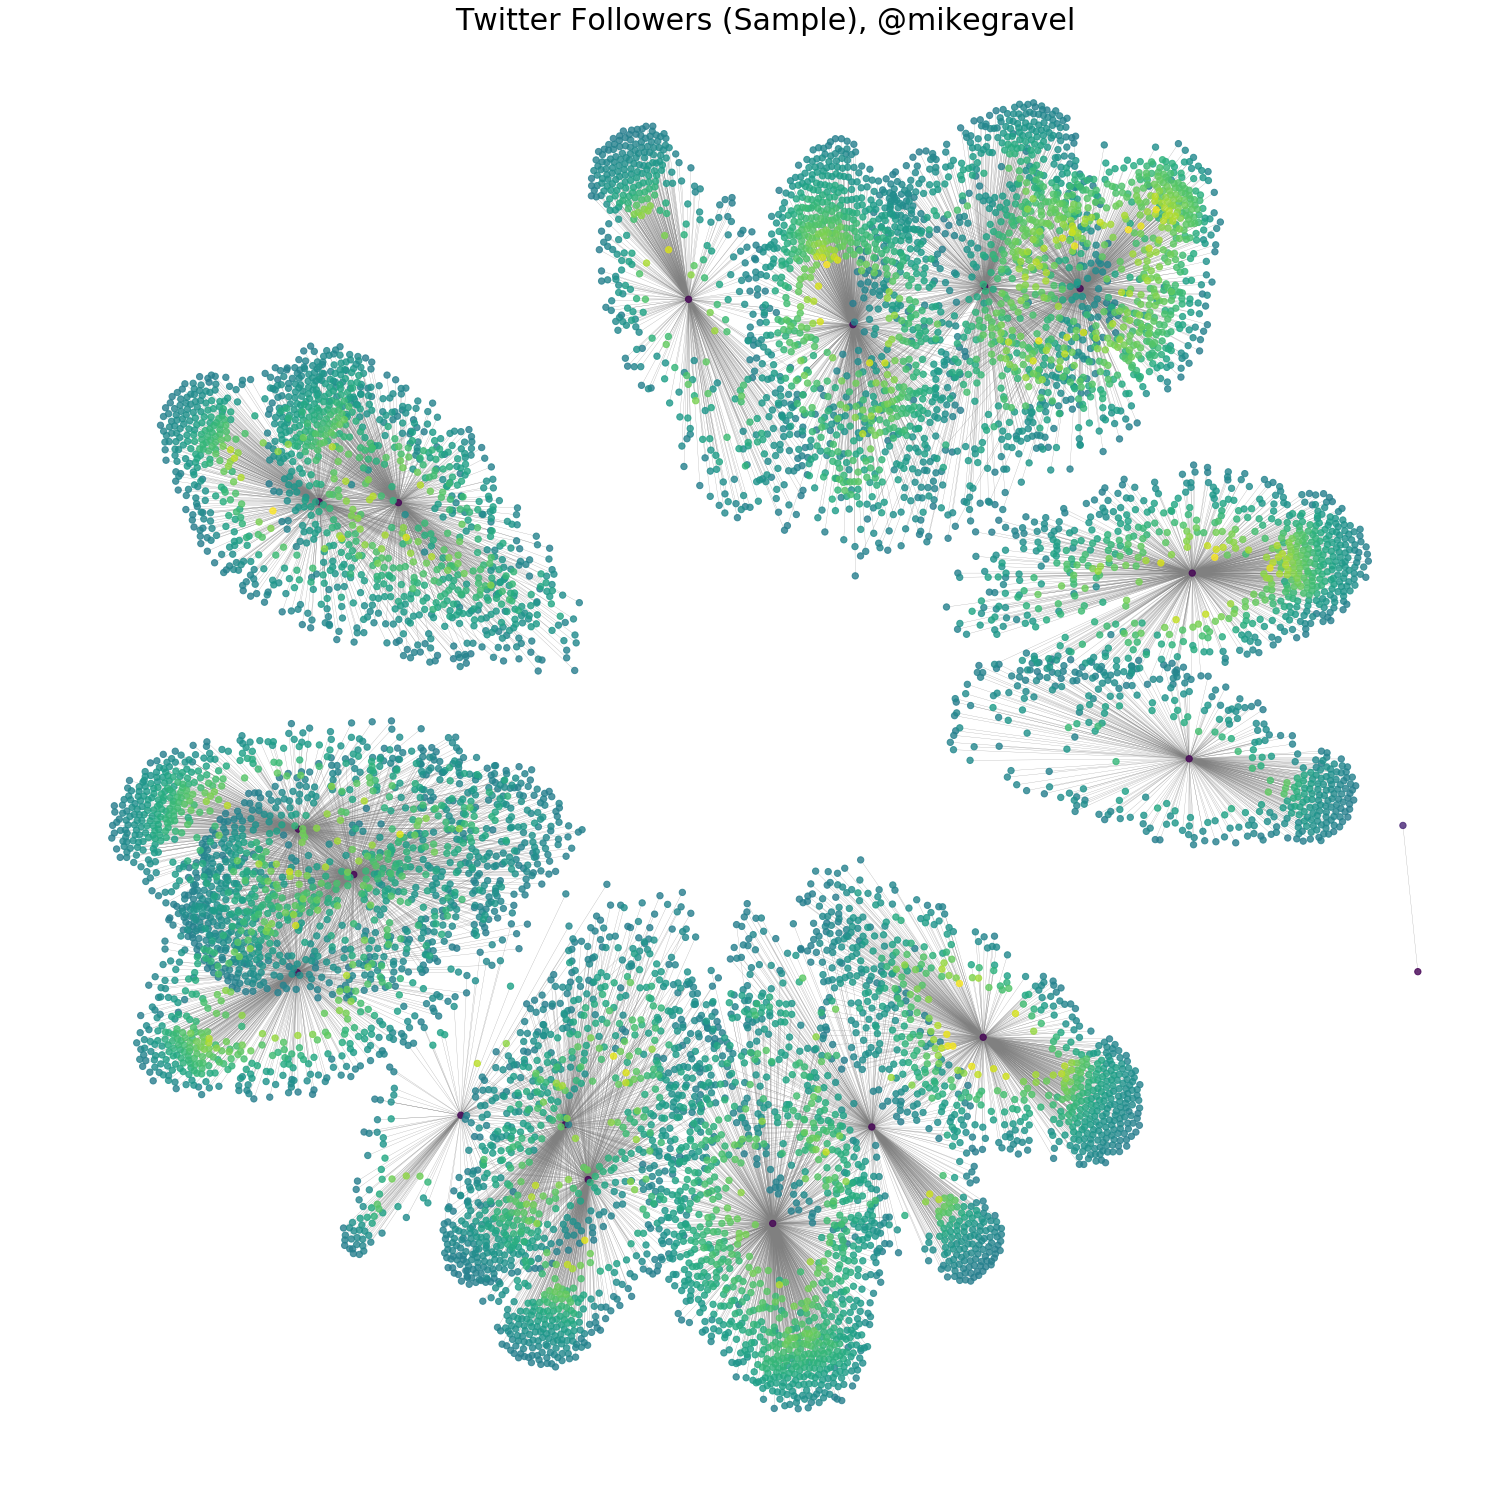

In [18]:
#read graph frpmo data frame
G=nx.from_pandas_edgelist(master1, 'source', 'screen_name')

#set node attributes use within plot
nx.set_node_attributes(G, pd.Series(master1.followers_count.values, index=master1.screen_name).to_dict(), 'followers_count')
nx.set_node_attributes(G, pd.Series(master1.verified.values, index=master1.screen_name).to_dict(), 'verified')
nx.set_node_attributes(G, pd.Series(master1.log_fc.values, index=master1.screen_name).to_dict(), 'log_fc')

degree=G.degree()
nodes=G.nodes()

#n_color will set color of nodes to degree; each degree in this network is 1.
n_color=np.asarray([degree[n] for n in nodes])

#follow will set the node_color to the log of the follower count for each user.
follow = np.asarray([G.nodes(data='log_fc', default=0)[n] for n in nodes])

#there are very few verified followers; 'verify' may be used as node_color to highlight them.
verify = np.asarray([G.nodes(data='verified', default=0)[n] for n in nodes])

#fix node positioning within spring_layout
fixed_nodes = [n for n in G.nodes()]

#stop the deprecated message generated by Matplotlib
import warnings
from matplotlib.cbook.deprecation import MatplotlibDeprecationWarning

warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)

#make the figure larger
fig = plt.figure(figsize=(20,20))

#set parameters for the layout
pos = nx.spring_layout(G,weight = 'log_fc', k =.1)

#plot
nx.draw(G,
        pos,
        node_color=follow,
        with_labels = False, 
        node_size=40,
        edge_color='gray', 
        font_size= 12,
        font_color='black',
        cmap='viridis',
        width=.25,
        alpha = .8)

#nx.draw_networkx_edge_labels(G, pos)
plt.title('Twitter Followers (Sample), @mikegravel\nNodes Colored by Degree',fontsize=30)
plt.show()


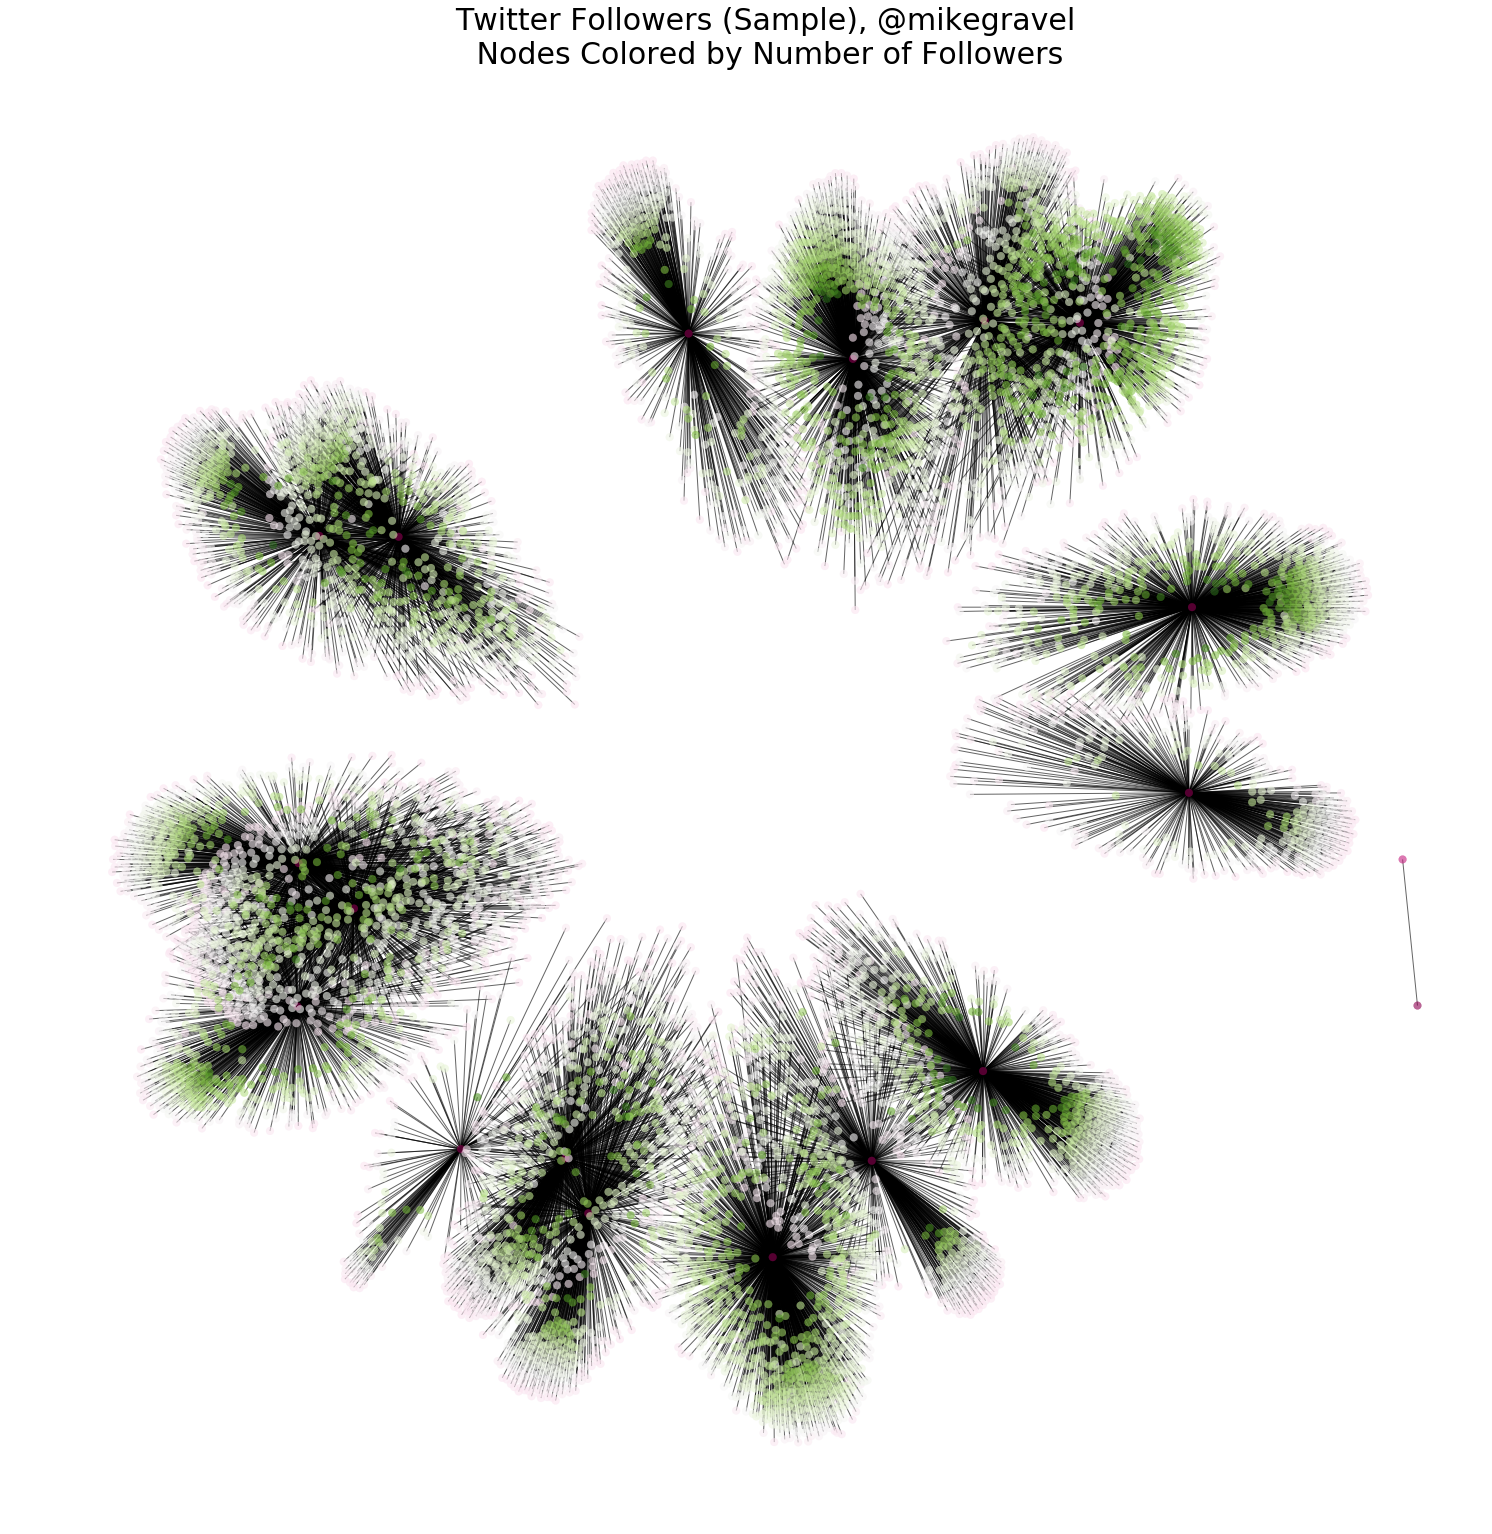

In [19]:
#different plot
plt.figure(figsize = (20,20))
nx.draw(G, 
        pos=pos, 
        node_color=follow, 
        cmap=plt.cm.PiYG, 
        edge_color="black", 
        linewidths=0.3, 
        node_size=60, 
        alpha=0.6, 
        with_labels=False)
plt.title('Twitter Followers (Sample), @mikegravel\n Nodes Colored by Number of Followers',fontsize=30)
plt.savefig('graphfinal.png')
plt.show()

## Centrality Analysis

For the analysis, we find the top 10 users as measured by various measures of centrality.

### Betweenness

In [82]:
G_dict = dict(nx.betweenness_centrality(G))
ordered_G = sorted(G_dict, key = G_dict.get,reverse = True)

print("Top 10, betweenness centrality:")

for i in range(10):
    print(ordered_G[i])
    
print("\n")

Top 10, betweenness centrality:
helloise7
tucsonmike
robyn459
kimfinnie
thesecondgoing
ajfeather
zacharywelliott
acttogetherfl
goddessmasha
jarongubernick




### Degree

In [83]:
G_dict = dict(nx.degree_centrality(G))
ordered_G = sorted(G_dict, key = G_dict.get,reverse = True)

print("Top 10, degree centrality:")

for i in range(10):
    print(ordered_G[i])
    
print("\n")

Top 10, degree centrality:
helloise7
tucsonmike
robyn459
kimfinnie
thesecondgoing
ajfeather
zacharywelliott
acttogetherfl
goddessmasha
jarongubernick




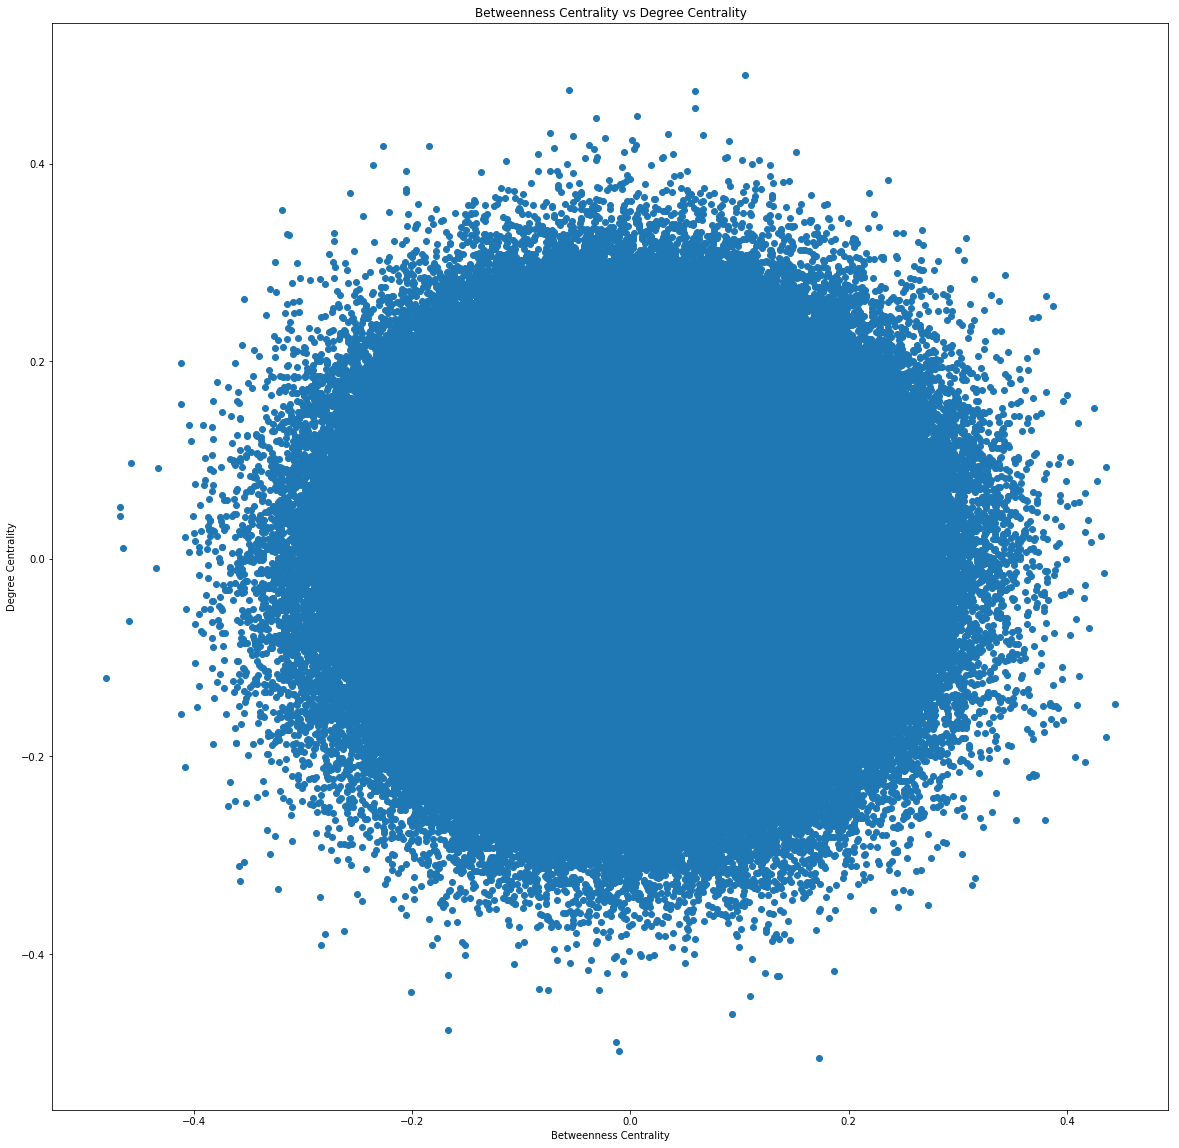

In [20]:
# Compute the betweenness centrality of G: bet_cen
bet_cen = nx.betweenness_centrality(G)
list_bc = list(bet_cen.values())
list_bc2 = [x+(.1*np.random.randn(100)) for x in list_bc]

# Compute the degree centrality of T: deg_cen
deg_cen = nx.degree_centrality(G)
list_dc = list(deg_cen.values())
list_dc2 = [x+(.1*np.random.randn(100)) for x in list_dc]

# Display the plot
plt.figure(figsize = (20,20))

# Create a scatter plot of betweenness centrality and degree centrality
plt.scatter(list_bc2, list_dc2)

ax = fig.add_subplot(111)
plt.title('Betweenness Centrality vs Degree Centrality')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Degree Centrality')
plt.show()

### PageRank

In [86]:
G_dict = dict(nx.pagerank(G))
ordered_G = sorted(G_dict, key = G_dict.get,reverse = True)

print("Top 10, PageRank:")

for i in range(10):
    print(ordered_G[i])
    
print("\n")

Top 10, PageRank:
helloise7
tucsonmike
robyn459
kimfinnie
thesecondgoing
ajfeather
zacharywelliott
acttogetherfl
goddessmasha
jarongubernick




### Centrality Comparision by Verified User Status

Twitter users can apply for a "verified" status, meaning that Twitter has vetted that the person is (in real life) who they say they are in their Twitter username.

Someone who takes the time to acquire verified status might also have higher centrality--but do they?

We will find out by comparing average centrality as measured by betweenness and average degree connectivity.

Count how many are verified:

In [87]:
#df = pd.DataFrame({'a':list('abssbab')})
master1.groupby('verified').count()

screen_name  followers_count  source  log_fc
verified                                              
False            8985             8985    8985    8985
True              447              447     447     447

In [27]:
verified_df = master1[master1['verified'] == True] #filter by verification status
unverified_df = master1[master1['verified'] == False]

In [28]:
G_verified = nx.from_pandas_edgelist(verified_df, 'source', 'screen_name')
G_unverified = nx.from_pandas_edgelist(unverified_df, 'source', 'screen_name')

In [55]:
def avg_bet_cent(G):
    bet_cen = nx.betweenness_centrality(G)
    list_bc = list(bet_cen.values())
    avg_bet = np.average(list_bc)
    return avg_bet

def overall_average_deg_connect(G):
    avg_dc = nx.average_degree_connectivity(G)
    list_adc = list(avg_dc.values())
    overall_avg = np.average(list_adc)
    return overall_avg

In [41]:
avg_bet_cent_v = avg_bet_cent(G_verified)
print(avg_bet_cent_v)

avg_bet_cent_u = avg_bet_cent(G_unverified)
print(avg_bet_cent_u)

0.00019010122719067385
7.220644789773679e-06


In [56]:
overall_avg_deg_v = overall_average_deg_connect(G_verified)
print(overall_avg_deg_v)

overall_avg_deg__u = overall_average_deg_connect(G_unverified)
print(overall_avg_deg__u)


4.015020773410035
33.56522491777333


## Conclusion

Interesting results!! While the betweenness centrality for unverified users is orders of magnitude lower than for verified users, the overall average degree connectivity of the unverified users is much higher! This latter fact *may* be an artifact of the data sampling. It is interesting to note that the verified users seems much more likely to be a node in between--perhaps reflecting that they are more trusted within the network. Given that fact, it may make sense for the campaign to target verified Twitter users to broadcast their message to more groups.

## Resources:  
- DataCamp NetworkX Python Graph Tutorial (https://www.datacamp.com/community/tutorials/networkx-python-graph-tutorial)

- [Python Graph Gallery](https://python-graph-gallery.com/324-map-a-color-to-network-nodes/)

- [University of Cambridge: Network Analysis with Python](https://www.cl.cam.ac.uk/teaching/1314/L109/tutorial.pdf)

- [Medium: Visualising Twitter Interaction with NetworkX](https://medium.com/future-vision/visualizing-twitter-interactions-with-networkx-a391da239af5)

- [Interaction Network](https://github.com/ugis22/analysing_twitter/blob/master/Jupyter%20Notebook%20files/Interaction%20Network.ipynb)

- [NetworkkX Documentation](https://networkx.github.io/documentation/stable/reference/algorithms/centrality.html)

- [Stack Overflow: NetworkX Degree Centrality](https://stackoverflow.com/questions/50241195/networkx-degree-centrality)

- Twitter API access code adapted from: [Stack Abuse](https://stackabuse.com/accessing-the-twitter-api-with-python/)

- Stack Overflow:[How to iterate through a nested dictionary](https://stackoverflow.com/questions/43752962/how-to-iterate-through-a-nested-dict/43753431)

- [How to Get a User List Using Twython](https://www.silkstream.net/blog/2014/06/playing-with-followers-with-twython-csv.html)

- [NetworkX Tutorial](https://networkx.github.io/documentation/stable/tutorial.html)